In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:80% !important; }</style>"))

In [28]:
import warnings
warnings.simplefilter(action='ignore')

In [3]:
import seaborn as sns
import matplotlib.mlab as ml
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.ticker as plticker

def stdfigsize(scale=1, nx=1, ny=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.
    -------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    """
    if ratio < 0:
        ratio = 1.61803398875
    return((7*ratio*scale*nx, 7*scale*ny))

def stdrcparams(usetex=False):
    """
    Set several mpl.rcParams and sns.set_style for my taste.
    ----
    usetex = True
    ----
    """
    sns.set_style("white")
    sns.set_style({"xtick.direction": "in",
                 "ytick.direction": "in"})
    rcparams = {'text.usetex': usetex,
              'font.family': 'sans-serif',
              'font.sans-serif': ['Helvetica'],
             # 'text.latex.unicode': True,
              'text.latex.preamble': [r"\usepackage[T1]{fontenc}",
                                      r"\usepackage{lmodern}",
                                      r"\usepackage{amsmath}",
                                      r"\usepackage{mathptmx}"
                                      ],
              'axes.labelsize': 30,
              'axes.titlesize': 30,
              'ytick.right': 'on',
              'xtick.top': 'on',
              'xtick.labelsize': '25',
              'ytick.labelsize': '25',
              'axes.linewidth': 1.8,
              'xtick.major.width': 1.8,
              'xtick.minor.width': 1.8,
              'xtick.major.size': 14,
              'xtick.minor.size': 7,
              'xtick.major.pad': 10,
              'xtick.minor.pad': 10,
              'ytick.major.width': 1.8,
              'ytick.minor.width': 1.8,
              'ytick.major.size': 14,
              'ytick.minor.size': 7,
              'ytick.major.pad': 10,
              'ytick.minor.pad': 10,
              'axes.labelpad': 15,
              'axes.titlepad': 15,
              "xtick.direction": "in",
              "ytick.direction": "in",
              'legend.fontsize': 20}
    mpl.rcParams.update(rcparams) 

mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['lines.color'] = '#3690c0'

stdrcparams(usetex=True)
figsize=stdfigsize(ratio=-1)
xs,ys=figsize

def custom_frame(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.tick_params(axis='x',length=10,direction='out')
    ax.tick_params(axis='x',which='minor',direction='out')
    ax.tick_params(axis='y',length=10,direction='out')
    ax.tick_params(axis='y',which='minor',direction='out')

In [4]:
import pickle
import itertools
import math
import random
import pandas as pd
import numpy as np
import networkx as nx

from datetime import date

In [5]:
def make_node_name(node):
    node = node.title()
    text = node.split('_')    
    if len(text)<3:
        return ','.join([text[0],text[1].upper()])
    else:
        city = ' '.join(text[0:-1])
        state = text[-1]
        state = state.upper()
        return ','.join([city,state])

In [6]:
df_air = pd.read_pickle('../data/networks/US_air_1990_2018.pkl')
nodes = set(df_air.source.unique())|set(df_air.target.unique())
df_air = df_air[df_air.source != df_air.target]
year = list(df_air.index.get_level_values(0).unique())
month = list(df_air.index.get_level_values(1).unique())
graphs_air = []
date_air = []
for y in year:
    for m in month:
#        if y != 2018 or m != 12:
        df = df_air.loc[y,m]
        date_air.append(date(y,m,1))
        G = nx.from_pandas_edgelist(df_air.loc[y,m], edge_attr=True)
        G.add_nodes_from(nodes)
        graphs_air.append(G)
        

n = date_air.index(date(2004,1,1))
graphs_air = graphs_air[n:]
date_air =  date_air[n:]

del df_air

In [7]:
import datetime
import calendar

def add_months(sourcedate, months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    return datetime.date(year, month, day)

In [8]:
import glob, os

In [9]:
import collections

from scipy.stats import sem, t
from scipy import mean
    
def get_survival_time(gamma,N_end):
    
    
    files = glob.glob(f'../simulation6/results/model_graphs_gamma{gamma}_Nend{N_end}*.pickle.dat') + \
    glob.glob(f'../simulation6/presults/model_graphs_gamma{gamma}_Nend{N_end}*.pickle.dat')
    G = pickle.load(open(files[0],'rb'))[0]
    edges_time = dict((edge,[]) for edge in list(G.edges()))
    for f in files:
        graphs = pickle.load(open(f,'rb'))
        for edge in list(G.edges()):
            a = (sum([g.has_edge(*edge) for g in graphs])-1)/12
            edges_time[edge].append(a) 
            
    
    files = glob.glob(f'../simulation6/results/model_graphs_null_gamma{gamma}_Nend{N_end}*.pickle.dat')+ \
    glob.glob(f'../simulation6/presults/model_graphs_null_gamma{gamma}_Nend{N_end}*.pickle.dat')  
    G = pickle.load(open(files[0],'rb'))[0]
    edges_time_null = dict((edge,[]) for edge in list(G.edges()))
    for f in files:
        graphs = pickle.load(open(f,'rb'))
        for edge in list(G.edges()):
            a = (sum([g.has_edge(*edge) for g in graphs])-1)/12
            edges_time_null[edge].append(a) 
    
    confidence = 0.95
    x,y_mean,y_up,y_low = [],[],[],[]
    for e,v in edges_time.items():
        x.append(e)
        n=len(v)
        std_err = sem(v)
        m = np.mean(v)
        h = std_err * t.ppf((1 + confidence) / 2, n - 1)
        y_mean.append(m)
        y_up.append(m+h)
        y_low.append(m-h)
    
    x = [i for _,i in sorted(zip(y_mean,x))]
    y_up = [i for _,i in sorted(zip(y_mean,y_up))]
    y_low = [i for _,i in sorted(zip(y_mean,y_low))]
    y_mean = sorted(y_mean)
    
#     y_mean_null,y_up_null,y_low_null = [],[],[]
#     for e in x:
#         v=edges_time_null[e]
#         std_err = sem(v)
#         m = np.mean(v)
#         h = std_err * t.ppf((1 + confidence) / 2, n - 1)
#         y_mean_null.append(m)
#         y_up_null.append(m+h)
#         y_low_null.append(m-h)

    confidence = 0.95
    x_null,y_mean_null,y_up_null,y_low_null = [],[],[],[]
    for e,v in edges_time_null.items():
        n=len(v)
        x_null.append(e)
        std_err = sem(v)
        m = np.mean(v)
        h = std_err * t.ppf((1 + confidence) / 2, n - 1)
        y_mean_null.append(m)
        y_up_null.append(m+h)
        y_low_null.append(m-h)
        
    x_null = [i for _,i in sorted(zip(y_mean_null,x_null))]
    y_up_null = [i for _,i in sorted(zip(y_mean_null,y_up_null))]
    y_low_null = [i for _,i in sorted(zip(y_mean_null,y_low_null))]
    y_mean_null = sorted(y_mean_null)
    
    return(x,y_mean,y_up,y_low,x_null,y_mean_null,y_up_null,y_low_null)

In [10]:
gamma=0.01
N_end=2092
data_1 = get_survival_time(gamma,N_end)

In [11]:
x,y_mean,y_up,y_low=data_1[0:4]

In [12]:
distance = pd.read_pickle('../data/us_air_distance.pkl')
dict_dist = distance.set_index(['source_origin','target_origin']).to_dict()['distance']
dict_dist.update(distance.set_index(['target_origin','source_origin']).to_dict()['distance'])

In [13]:
co2_graphs_air = graphs_air[-12::]
def get_times(a,b):
    times = 0
    for G in co2_graphs_air:
        if G.has_edge(a,b):
            times+=G.get_edge_data(a,b)['weight']
        else:
            times+=0
    return times

In [14]:
bins=1
x,y = [],[]
population_i,population_j,dist_ij,times_ij = [],[],[],[]
for e,yi in zip(data_1[0],y_mean):
    a,b = e
#     if 'ak'!=a[-2::] and 'ak'!=b[-2::] and 'hi'!=a[-2::] and 'hi'!=b[-2::] and 'tt'!=a[-2::] and 'tt'!=b[-2::]:
    if (a,b) in list(dict_dist.keys()):
        d = dict_dist[(a,b)]
    elif (b,a) in list(dict_dist.keys()):
        d = dict_dist[(b,a)]
    else:
        d = np.nan
#     if a in list(population.keys()):
#         pa = population[a]
#     else:
#         pa = np.nan
#     if b in list(population.keys()):
#         pb = population[b]
#     else:
#         pb = np.nan
#     x.append(pa*pb/d**2)
#     population_i.append(pa)
#     population_j.append(pb)
    dist_ij.append(d)
    times_ij.append(get_times(a,b))
    y.append(yi)
    
x = np.log(np.array(x))
# x = np.array(x)
#     y = np.array(y)
# x = x[0:bins*(len(x)//bins)]
# x = np.nanmean(x.reshape(-1, bins), axis=1)
y = np.array(y)
# print(x)

In [15]:
before = sum([x*n for i,x,n in sorted(zip(y,dist_ij,times_ij))])*32.5*1.60934*3.16*10**(-6)

In [16]:
after = sum([x*n for i,x,n in sorted(zip(y,dist_ij,times_ij)) if i <=14])*32.5*1.60934*3.16*10**(-6)

In [17]:
print(before,after,after/before)

15634.399704239135 11738.160969573766 0.7507906406148145


In [18]:
# f, ax = plt.subplots(nrows=1, ncols=1, figsize=(xs*0.8,ys*0.8))
# # plt.title('')
# plt.plot([100-sum([x*n for i,x,n in sorted(zip(y,dist_ij,times_ij)) if i <=l])*32.5*1.60934*3.16*10**(-6)/before*100 for l in range(30)])
# ax.set_ylabel(r'$CO_2$ emission \%')
# ax.set_xlabel(r'Time')
# # labels = [item.get_text() for item in ax.get_xticklabels()]
# # labels[1] = '2019'

# plt.xticks([0,10,20,30],[2018,2028,2038,2048])
# custom_frame(ax)
# plt.show()

In [22]:
def get_dist(a,b):
    if (a,b) in list(dict_dist.keys()):
        d = dict_dist[(a,b)]
    elif (b,a) in list(dict_dist.keys()):
        d = dict_dist[(b,a)]
    return d
    
# def get_co2(para_list=[(0.01,2092),(0.02,2092),(0.04,2092),(0.04,1255)]): 
para_list=[(0.02,2092),(0.04,2092),(0.02,1255),(0.04,1255)]
files = []
for gamma, N_end in para_list:
    files+=glob.glob(f'../simulation4/presults/model_graphs_gamma{gamma}_Nend{N_end}*.pickle.dat')+glob.glob(f'../simulation4/fresults/model_graphs_gamma{gamma}_Nend{N_end}*.pickle.dat')
print(len(files))

190


In [23]:
G = pickle.load(open(files[0],'rb'))[0]
edges_time = dict((edge,[]) for edge in list(G.edges()))
time,gammas,nends,co2_hist = [],[],[],[]
for f in files:
    graphs = pickle.load(open(f,'rb'))
    co2_t=[]
    gamma = f.strip('.pickle.dat').split('_')[-2].strip('gamma')
    nend = f.strip('.pickle.dat').split('_')[-1].strip('Nend')[0:4]
    co2=sum([get_times(a,b)*get_dist(a,b)*32.5*1.60934*3.16*10**(-6) for a,b in list(graphs[0].edges())])
    co2_t.append(co2)
    N =  len(graphs)
    for G0,G1 in zip(graphs,graphs[1::]):
        edges = list(nx.difference(G0,G1).edges())
        co2-=sum([get_times(a,b)*get_dist(a,b)*32.5*1.60934*3.16*10**(-6) for a,b in edges])
        co2_t.append(co2)
    time += [add_months(date_air[-1],j) for j in range(N)]
    gammas += [gamma] * N
    nends += [nend] * N
    co2_hist += co2_t 


In [24]:
map_dict ={'3138':'50\%','2092':'67\%','1569':'75\%','1255':'80\%'}
df = pd.DataFrame()
df['time'] = time
df['CO2'] = co2_hist
df['$\gamma$'] = gammas
df['$N_{end}$'] =nends
df['CO2'] = df['CO2']/15634.399704-1.0
df['$R_f$'] = [map_dict[i] for i in nends]

In [25]:
data = df

In [26]:
data.head()

,time,CO2,$\gamma$,$N_{end}$,$R_f$
0,2018-12-01,1.529932e-11,0.02,2092,67\%
1,2019-01-01,-6.314384e-03,0.02,2092,67\%
2,2019-02-01,-1.265103e-02,0.02,2092,67\%
3,2019-03-01,-1.958647e-02,0.02,2092,67\%
4,2019-04-01,-2.595967e-02,0.02,2092,67\%


In [34]:
data.to_pickle('../data/co2_history_from_simulations.pkl')

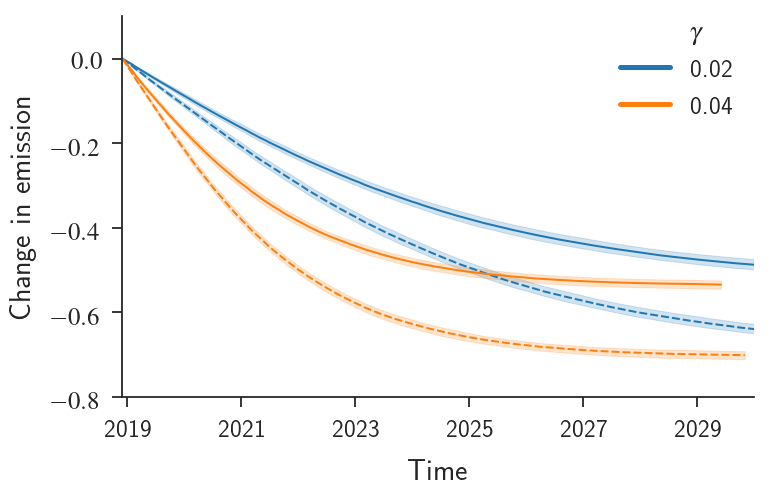

In [37]:
# colors_g = ['#c7e9c0','#74c476','#006d2c']
# colors_b = ['#deebf7','#9ecae1','#3182bd']
# colors_or = ['#fee6ce','#fdae6b','#e6550d']
colors = sns.color_palette(None,2)
fig,ax = plt.subplots(figsize=(xs,ys))

sns.lineplot(x="time", y="CO2",hue='$\gamma$',style='$R_f$',palette=colors, style_order=['67\%','80\%'],legend = 'full', 
             ci='sd',data=data[data['$\gamma$']!='0.01'],ax=ax,linewidth=2)
plt.xlabel('Time')
plt.ylabel(r'Change in emission')
# plt.axhline(y=2000,linestyle='--',c='black')
# plt.axhline(y=1000,linestyle='--',c='black')
plt.xlim(date(2018,12,1),date(2030,1,1))
plt.ylim(-0.8,0.1)
# plt.yticks([1000,2000,3000,4000,5000,6000,7000])
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles=handles[0:3], labels=labels[0:3],loc='upper right', bbox_to_anchor=(1.0, 1.05),
          ncol=1, fancybox=False, shadow=False,frameon=False,fontsize=25)#,title_fontsize=25)

custom_frame(ax)
plt.savefig('../Figs/A_Fig.5B.pdf',transparent=True)
plt.show()

In [51]:
data_2000_1 = get_co2(0.01,2092)

In [52]:
data_2000_2 = get_co2(0.02,2092)

In [53]:
data_2000_4 = get_co2(0.04,2092)

In [40]:
data_1000_1 = get_co2(0.01,1255)

In [41]:
data_1000_2 = get_co2(0.02,1255)

In [54]:
data_1000_4 = get_co2(0.04,1255)

KeyboardInterrupt: 

In [ ]:
from scipy.stats import sem, t
from scipy import mean
def get_mean_bound(input_arr):
    confidence = 0.95
    x,y_mean,y_up,y_low = [],[],[],[]
    for v in input_arr.T:
#         v=np.array([k[i] for k in list_list])
        std_err = sem(v)
        m = np.mean(v)
        n=len(v)
        h = std_err * t.ppf((1 + confidence) / 2, n - 1)
        y_mean.append(m)
        y_up.append(m+h)
        y_low.append(m-h)
    return y_mean,y_low,y_up
    
def plot_mean_and_CI(mean, lb, ub, label=None,color_mean=None, color_shading=None):
    # plot the shaded range of the confidence intervals
    plt.fill_between(range(len(mean)), ub, lb,
                     color=color_shading, alpha=.5,label=None)
    # plot the mean on top
    ax.plot(range(len(mean)),mean,color_mean,label=label)

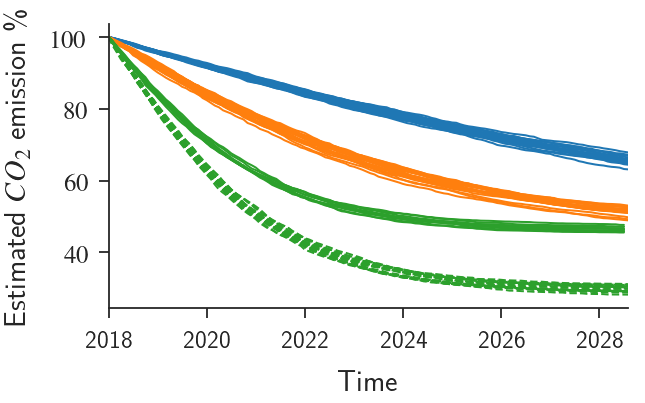

In [50]:
colors = sns.color_palette(None, 3)
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(xs*0.8,ys*0.8))
# for k,d,label in zip(colors,[data_2000_1,data_2000_2,data_2000_4],['0.01','0.02','0.04']):
#     plot_mean_and_CI(*get_mean_bound(np.array(d)/d[0]*100),color_mean=k,label=label)
# # plt.title('')
for i,d in enumerate(data_2000_1):
    if i==0:
        plt.plot(np.array(d)/d[0]*100,label='(67\%,0.01)',color=colors[0],linewidth=2)
    else:
        plt.plot(np.array(d)/d[0]*100,color=colors[0],linewidth=2)
        
for i,d in enumerate(data_2000_2):
    if i==0:
        plt.plot(np.array(d)/d[0]*100,label='(67\%,0.02)',color=colors[1],linewidth=2)
    else:
        plt.plot(np.array(d)/d[0]*100,color=colors[1],linewidth=2)
for i,d in enumerate(data_2000_4):
    if i==0:
        plt.plot(np.array(d)/d[0]*100,label='(67\%,0.04)',color=colors[2],linewidth=2)
    else:
        plt.plot(np.array(d)/d[0]*100,color=colors[2],linewidth=2)
        
for i,d in enumerate(data_1000_4):
    if i==0:
        plt.plot(np.array(d)/d[0]*100,label='(80\%,0.04)',color=colors[2],linestyle='--',linewidth=2)
    else:
        plt.plot(np.array(d)/d[0]*100,color=colors[2],linestyle='--',linewidth=2)
ax.set_ylabel(r'Estimated $CO_2$ emission \%')
ax.set_xlabel(r'Time')
# labels = [item.get_text() for item in ax.get_xticklabels()]
# labels[1] = '2019'
# plt.legend(title='$(N_{end},\gamma)$',title_fontsize=30, bbox_to_anchor=(1.0, 0.45),frameon=False)
plt.xticks([24*i for i in range(6)],[2018+2*i for i in range(6)])
plt.xlim(0,len(data_2000_4[0]))
plt.yticks()
custom_frame(ax)
plt.tight_layout()
plt.savefig('../Figs/A_Fig.5B.pdf',transparent=True)

plt.show()

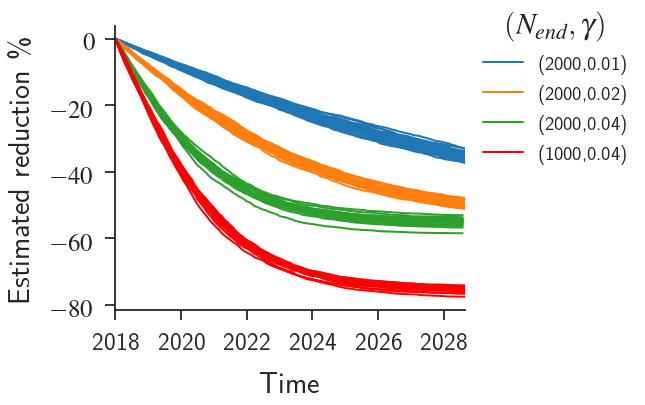

In [259]:
colors = sns.color_palette(None, 3)
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(xs*0.8,ys*0.8))
# for k,d,label in zip(colors,[data_2000_1,data_2000_2,data_2000_4],['0.01','0.02','0.04']):
#     plot_mean_and_CI(*get_mean_bound(np.array(d)/d[0]*100),color_mean=k,label=label)
# # plt.title('')
for i,d in enumerate(data_2000_1):
    if i==0:
        plt.plot(-(100-np.array(d)/d[0]*100),label='(2000,0.01)',color=colors[0],linewidth=2)
    else:
        plt.plot(-(100-np.array(d)/d[0]*100),color=colors[0],linewidth=2)
        
for i,d in enumerate(data_2000_2):
    if i==0:
        plt.plot(-(100-np.array(d)/d[0]*100),label='(2000,0.02)',color=colors[1],linewidth=2)
    else:
        plt.plot(-(100-np.array(d)/d[0]*100),color=colors[1],linewidth=2)
for i,d in enumerate(data_2000_4):
    if i==0:
        plt.plot(-(100-np.array(d)/d[0]*100),label='(2000,0.04)',color=colors[2],linewidth=2)
    else:
        plt.plot(-(100-np.array(d)/d[0]*100),color=colors[2],linewidth=2)
        
for i,d in enumerate(data_1000_4):
    if i==0:
        plt.plot(-(100-np.array(d)/d[0]*100),label='(1000,0.04)',color='red',linewidth=2)
    else:
        plt.plot(-(100-np.array(d)/d[0]*100),color='red',linewidth=2)
ax.set_ylabel(r'Estimated reduction \%')
ax.set_xlabel(r'Time')
# labels = [item.get_text() for item in ax.get_xticklabels()]
# labels[1] = '2019'
plt.legend(title='$(N_{end},\gamma)$',title_fontsize=30, bbox_to_anchor=(1.0, 0.45),frameon=False)
plt.xticks([24*i for i in range(6)],[2018+2*i for i in range(6)])
plt.xlim(0,len(data_2000_4[0]))
custom_frame(ax)
plt.tight_layout()
plt.savefig('../Figs/Fig.SI_CO2A.pdf',transparent=True)

plt.show()

In [128]:
# colors = sns.color_palette(None, 3)
# f, ax = plt.subplots(nrows=1, ncols=1, figsize=(xs*0.8,ys*0.8))
# for k,d,label in zip(colors,[data_2000_1,data_2000_2,data_2000_4],['0.01','0.02','0.04']):
#     plot_mean_and_CI(*get_mean_bound(np.array(d)/d[0][0]*100),color_mean=k,label=label)
# ax.set_ylabel(r'Estimated $CO_2$ emission \%')
# ax.set_xlabel(r'Time')
# plt.legend(title='$\gamma$')
# plt.xticks([0,10*12,20*12,30*12],[2018,2028,2038,2048])
# plt.ylim(40,100)
# custom_frame(ax)
# plt.show()

In [136]:
[(np.array(d)/d[0][0]*100).T[10*12-1] for  d in [data_2000_1,data_2000_2,data_2000_4]]

[array([64.86646391, 69.14167466, 67.31583528, 64.759883  , 65.93199815,
        66.09533961, 67.39211401, 67.52702234, 65.19757418, 65.51113258,
        65.81043318, 65.48222478, 65.09592171, 66.76504902, 66.62802004,
        66.18710243, 64.67731316, 67.42592487, 67.04751555, 68.43469116,
        65.16523699, 65.58427474, 67.99443744, 66.69587328, 65.89524418,
        67.13637438, 65.67535676, 64.18335617, 65.05943943, 65.97089496]),
 array([49.8904152 , 50.94098546, 52.21424248, 52.35586583, 50.73391178,
        50.81821957, 53.05730669, 51.61637812, 50.78451231, 52.56451362,
        53.24813196, 49.92620187, 51.73738068, 52.8145383 , 50.58517168,
        50.97668968, 50.40211224, 51.24351672, 51.59172852, 50.76077504]),
 array([44.05008917, 44.89171565, 44.92271026, 43.42105365, 46.12226377,
        44.90680014, 45.44280003, 45.81157554, 46.07040311, 44.01420841,
        44.97557944, 47.06080668, 43.87557785, 45.46431199, 46.52880917,
        45.83332747, 41.56743763, 45.25814957, 

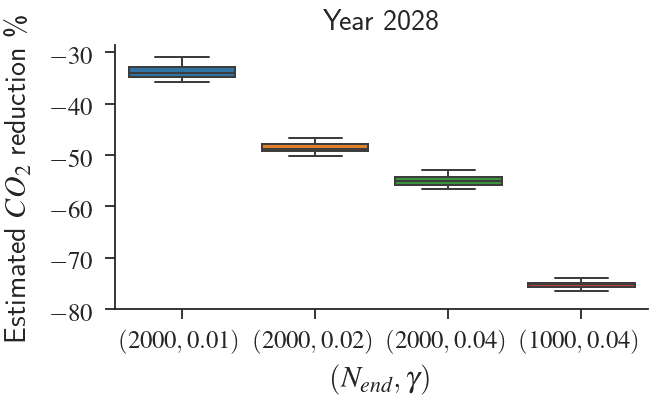

In [261]:
colors=sns.color_palette(None, 3).append('red')
fig,ax = plt.subplots(figsize=(xs*0.8,ys*0.8))
sns.boxplot(data=[-(100-(np.array(d)/d[0][0]*100).T[10*12-1]) for  d in [data_2000_1,data_2000_2,data_2000_4,data_1000_4]],palette=colors,linewidth=2,showfliers=False,ax=ax)
# plt.xticks(rotation=-30,ha='left',ma='right')
# plt.yticks(fontsize=20)
ax.set_xlabel(r'$(N_{end},\gamma)$')
ax.set_ylabel(r'Estimated $CO_2$ reduction \%')
plt.xticks([0,1,2,3],['$(2000,0.01)$','$(2000,0.02)$','$(2000,0.04)$','$(1000,0.04)$'])
plt.title('Year 2028')
plt.yticks([-30,-40,-50,-60,-70,-80])
plt.tight_layout()
custom_frame(ax)
plt.savefig('../Figs/Fig.SI_CO2B.pdf',transparent=True)
plt.show()